In [ ]:
from pathlib import Path

from lightning.pytorch import Trainer

from eotorch.data import (
    SegmentationDataModule,
    SemanticSegmentationTask,
    get_segmentation_dataset,
)
from eotorch.processing import normalize

class_mapping = {
    1: "Baresoil",
    2: "Buildings",
    3: "Coniferous Trees",
    4: "Deciduous Trees",
    5: "Grass",
    6: "Impervious",
    7: "Water",
}

DATASET_DIR = Path.home()
IMG_DIR = DATASET_DIR / "sr_data"
LABEL_DIR = DATASET_DIR / "labels"

NORM_DIR = DATASET_DIR / "normalized"

assert Path(NORM_DIR).is_dir()
assert Path(LABEL_DIR).is_dir()

Dataset directory: /teamspace/studios/this_studio


### Normalization and other preprocessing

In [ ]:
for f in IMG_DIR.rglob("*.tif"):
    print(f)
    out_file = NORM_DIR / f.parent.name / f.name
    out_file.parent.mkdir(exist_ok=True, parents=True)
    out_path = normalize(
        img_path=f, limits=(0.1, 99.5), out_path=out_file, sample_size=0.2
    )

### Create a segmentation dataset and visualize some samples

The function to create the dataset can create different datasets based on which parameters you pass. E.g. you can either provide a label directory or not. For training, you obviously want labels, but there are cases where you might want a compatible dataset without labels.

If your dataset has a temporal component, you can match the relevant image and label files to each other via their file names by setting certain parameters. For example:

```python
image_filename_regex=r'.*_(?P<date>\d{4})_.*',
label_filename_regex=r'.*_(?P<date>\d{4})_.*',
date_format="%Y",
```
would use the provided regex to extract the dates from the filenames and then interpret those date as years

Use the 'plot_samples' function to sample some random patches from your dataset. You can set 'show_filepaths' to True in order to validate that the image files are matched with the correct label files. 

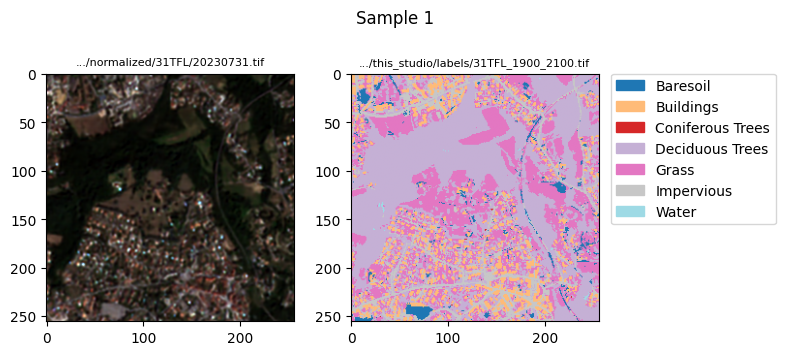

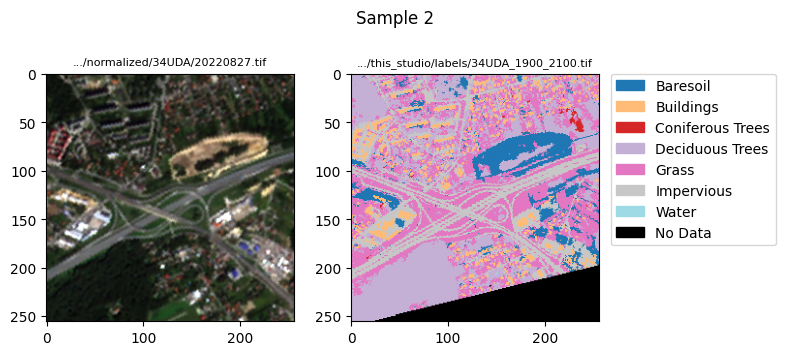

In [5]:
ds = get_segmentation_dataset(
    images_dir=NORM_DIR,
    labels_dir=LABEL_DIR,
    image_filename_regex=r"(?P<date>\d{8})\.tif",
    label_filename_regex=r".*(?P<start>\d{4})_(?P<stop>\d{4}).tif",
    image_date_format="%Y%m%d",
    label_date_format="%Y",
    all_image_bands=("B02", "B03", "B04", "B08", "B11", "B12"),
    rgb_bands=("B04", "B03", "B02"),
    class_mapping=class_mapping,
    reduce_zero_label=True,
    cache_size=50,
)
ds.plot_samples(n=2, patch_size=256, show_filepaths=True)


If you inspect the dataset in a Jupyter notebook, you should see a map preview including the bounds of your dataset. This can be used to further validate your setup.  
On the interactive map, you can measure distances, draw bounding boxes and export them as a .geojson file. These files can then be used to split your dataset.

In [ ]:
ds

### Splitting your dataset

We always need a validation set for training. Either you can split your data yourself or just provide your entire dataset as the train_dataset. In that case a default train/val split will be performed for you. 

You can either manually create a train and a validation (and test) dataset or create a single dataset and split it.

We provide some splitting functions for things like aoi-based splitting or file-based splitting. They can be found in the split module of eotorch.

#### File-based split:

Simply specify one or multiple files of your dataset that should be moved to the validation or test set.

In [ ]:
from eotorch.data import splits

train_ds, val_ds = splits.file_wise_split(
    dataset=ds,
    val_img_files="/teamspace/studios/this_studio/normalized/31TFL/20220716.tif",
)

#### AOI-based split:

Define an AOI for the splits. Can be done by providing a geojson file (recommended) or by providing the bounds of the AOI (see docstring of the function).  
You can also specify a buffer_size (in metres around the AOIs), this can be used to make sure there is no overlap (due to the patch size) between your datasets.  
Remember you can use the interactive map to draw and export bounding boxes in the right format!

In [ ]:
from eotorch.data import splits

train_ds, val_ds = splits.aoi_split(
    dataset=ds,
    val_aois="/teamspace/studios/this_studio/val_data.geojson",
    buffer_size=1000,
)

### Create a data module for training (everything related to data loading)

Use the 'train_sampler_config' to change the data patches are being sampled from your train dataset. The default is a simple sequential grid sampling with a stride of patch_size / 2.  
For checking for samplers are available, check https://torchgeo.readthedocs.io/en/stable/api/samplers.html

Parameters here will need to be adjusted based on the available GPU and other hardware.
We use caching when reading the files (per worker). This can use a lot of of RAM!

Rough guidelines for troubleshooting (more to follow):
- out of memory (RAM): Decrease number of workers and/or cache size (adjust cache size in dataset params). If still really pressed for RAM, reducing patch & batch size can also help, but shouldn't be necessary.
- Out of GPU memory: Reduce batch size
- Low GPU utilization: Increase number of workers (possibly while decreasing cache size) until you run into CPU / RAM limitations

In [17]:
module = SegmentationDataModule(
    train_dataset=train_ds,
    val_dataset=val_ds,
    batch_size=16,
    patch_size=256,
    num_workers=6,
    pin_memory=True,
    persistent_workers=True,
    # train_sampler_config={"type": "RandomGeoSampler", "length": 5000}, # this would sample 5000 patches randomly for each epoch
)

'SegmentationDataModule' has a method for previewing the datasets and samplers called 'preview_data'. Use it to validate your datasets!  
There should be no overlap between train/validation/test sets, etc.  
By default, only 100 samples will be taken for preview from each dataset, but you can set the 'max_samples' parameter to None to preview them all. Warning, this might take a long time if you have a really big dataset.  
If required, use the interactive map to measure the amount of overlap between your datasets and adjust the buffer_size parameter in case you were using an AOI-based split.  
This method will use the exact same sampling logic that will be used during training, so it is useful to verify once before starting a large training job.  
The function also provides a 'count_labels' parameter. If set to True, you will receive the distributions of class labels for each of your dataset (as sampled, so it might not reflect the actual amount of annotated pixels). Use this to make sure your val/test set labels are representative of the overall label distribution.

In [ ]:
module.preview_data_sampling(max_samples=100, count_labels=True)

### Create a task (PyTorch Lightning Module) for segmentation

The Lightning Module controls most of your hyperparameters and training configuration. Which model, loss and learning rate to use, which index to ignore in the loss function.  
Sensible defaults have been chosen, but as always, these parameters might have to be tweaked.

In [25]:
task = SemanticSegmentationTask(
    model="deepresunet",
    in_channels=6,
    num_classes=len(class_mapping),
    # loss="focal",
    ignore_index=-1,  # because reduce_zero_label=True
    # lr=1e-6,
)

Initializing model deepresunet with kwargs {'num_classes': 7, 'in_channels': 6, 'num_filters': 128}


### Create a PyTorch Lightning Trainer

This class allows you to modify many aspects of the model training

In [ ]:
from lightning.pytorch.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)

trainer = Trainer(
    callbacks=[
        LearningRateMonitor(logging_interval="epoch"),
        EarlyStopping(
            monitor="val_macro_f1",
            patience=35,
            mode="max",
        ),
        ModelCheckpoint(
            save_last=True,
            monitor="val_macro_f1",
            save_top_k=5,
            filename="{epoch}-{val_loss:.4f}-{val_macro_f1:.2f}",
            mode="max",
        ),
    ],
    max_epochs=150,
)

### Fit the trainer

This will run the actual training of the model

In [ ]:
trainer.fit(model=task, datamodule=module)

### Use your model to make predictions

Specify the weights to use and an input tif file. If your model was trained using eotorch, you don't need to specify things like patch_size and class_mapping again, as they will be read from the checkpoint.  
The results will be saved to a tif file (out_file_path if specified, otherwise in a 'predictions' folder in the same directory as your input file).  
If 'show_results' as set to True, you also get a preview of the results in the notebook.

In [ ]:
f = trainer.callbacks[-1].best_model_path
print(f"Using weights {f}")
out_file_path = "/teamspace/studios/this_studio/predictions/31TFL_20230731_preds.tif"
SemanticSegmentationTask.predict_on_tif_file(
    tif_file_path="/teamspace/studios/this_studio/normalized/31TFL/20230731.tif",
    checkpoint_path=f,
    show_results=True,
    out_file_path=out_file_path,
)